# Ejercicio 1: Regresor logístico binario

Modifica el código para que el conjunto de entrenamiento se divida en en entrenamiento, validación y test. Usa el conjunto de evaluación para determinar cuándo detener el entrenamiento. Añade un gráfico que muestre la evolución de la función de pérdida en el conjunto de entrenamiento y en el de validación.



## Semilla de aleatoriedad

In [ ]:
import os
# set before importing pytorch to avoid all non-deterministic operations on GPU
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)

set_seed(42)

## Generación de los datos

type(Xn) = <class 'numpy.ndarray'>, type(yn) = <class 'numpy.ndarray'>
Xn.shape = (300, 2)
yn.shape = (300,)
Xn[:3] = [[3.09426072 2.70442525]
 [3.97910621 2.82081396]
 [1.53645503 2.66854744]]
yn[:3] = [1 1 0]


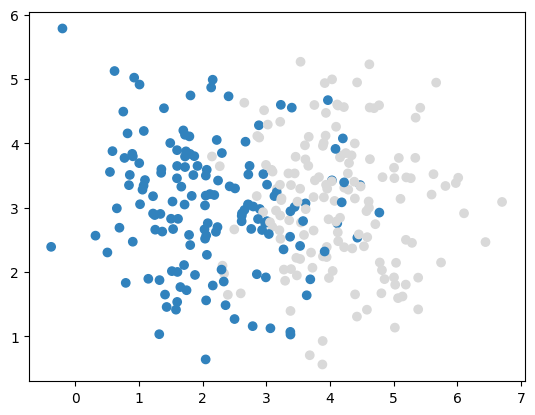

In [ ]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

class_centers = [[2,3], [4,3]]
dev = 1
samples = 300  # number of samples per class
features = 2  # dimensionality of the samples

Xn, yn = make_blobs(n_samples=samples, centers=class_centers, cluster_std=dev, n_features=features, random_state=4)

print(f"type(Xn) = {type(Xn)}, type(yn) = {type(yn)}")
print(f"Xn.shape = {Xn.shape}")  # bidimensional array
print(f"yn.shape = {yn.shape}")  # unidimensional array
print(f"Xn[:3] = {Xn[:3]}")  # first three samples
print(f"yn[:3] = {yn[:3]}")  # 0 for the first class, 1 for the second class

plt.scatter(Xn[:,0], Xn[:,1], c=yn, cmap='tab20c')  # cmap is the color map
plt.show()

## Inicialización de los tensores

In [ ]:
import numpy as np
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"  # global variable
print (f'Using {device}')

X = torch.from_numpy(np.float32(Xn)).to(device)
y = torch.from_numpy(np.float32(yn)).to(device)

print(f"type(X) = {type(X)}, type(y) = {type(y)}")
print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")
print(f"X[:3] = {X[:3]}")
print(f"y[:3] = {y[:3]}")

Using cpu
type(X) = <class 'torch.Tensor'>, type(y) = <class 'torch.Tensor'>
X.shape = torch.Size([300, 2])
y.shape = torch.Size([300])
X[:3] = tensor([[3.0943, 2.7044],
        [3.9791, 2.8208],
        [1.5365, 2.6685]])
y[:3] = tensor([1., 1., 0.])


## División de los datos

In [ ]:

mask = torch.ones(X.shape[0], dtype=bool).to(device)
mask[::4] = 0  # one every 4 elements for testing
mask[1::4] = 0  # one every 4 elements for validation
X_train, y_train = X[mask], y[mask]

val_mask = torch.logical_not(mask)
val_mask[::2] = False  # One every 2 validation elements for smaller validation set
X_val, y_val = X[val_mask], y[val_mask]

test_mask = torch.logical_not(mask | val_mask)
X_test, y_test = X[test_mask], y[test_mask]

print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}\n")
print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_val.shape}\n")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")


X_train.shape = torch.Size([150, 2])
y_train.shape = torch.Size([150])

X_val.shape = torch.Size([75, 2])
y_val.shape = torch.Size([75])

X_test.shape = torch.Size([75, 2])
y_test.shape = torch.Size([75])


## Funciones auxiliares

In [ ]:
def regressor(size):
    weights = torch.rand(size, dtype=torch.float32).to(device)
    bias = torch.rand(1, dtype=torch.float32).to(device)
    return weights, bias

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def forward(X, weights, bias):
    return sigmoid(torch.matmul(X,weights) + bias)  # bias is broadcasted to (batch_size, 1)

def binary_cross_entropy(y_truth, y_pred):
    m = 1 / y_truth.shape[0]  # y_truth.shape[0] is the size of the mini-batch
    return -m * (y_truth * torch.log(y_pred) +
                    (1 - y_truth) * torch.log(1 - y_pred)).sum()

## Entrenamiento

In [ ]:
def loss_backward(y_truth, y_pred, X):
    err = (y_pred - y_truth)
    grad_w = (1 / y_truth.shape[0]) * torch.matmul(err, X)
    grad_b = (1 / y_truth.shape[0]) * torch.sum(err)
    return grad_w, grad_b

def optimizer_step(weights, bias, grad_w, grad_b, lr=0.01):
    weights = weights - lr * grad_w
    bias = bias - lr * grad_b
    return weights, bias

# Funcion train modificada
def train(X_train, y_train, X_val, y_val, weights, bias, lr=0.01, training_steps=1000, valid_steps=100):
    train_losses = []
    val_losses = []
    for i in range(training_steps):
        # Forward pass on training data
        y_train_pred = forward(X_train, weights, bias)
        train_loss = binary_cross_entropy(y_train, y_train_pred)
        train_losses.append(train_loss.item())

        # Backward pass and optimization
        grad_w, grad_b = loss_backward(y_train, y_train_pred, X_train)
        weights, bias = optimizer_step(weights, bias, grad_w, grad_b, lr)

        # Evaluate on validation set
        if i % valid_steps == 0:
            y_val_pred = forward(X_val, weights, bias)
            val_loss = binary_cross_entropy(y_val, y_val_pred)
            val_losses.append(val_loss.item())
            print(f'Step [{i}/{training_steps}], Training Loss: {train_loss:.2f}, Validation Loss: {val_loss:.2f}')
            # Stop training if validation loss does not improve
            if len(val_losses) > 1 and val_losses[-1] >= val_losses[-2]:
                print("Validation loss did not improve. Stopping training.")
                break

    return weights, bias, train_losses, val_losses

In [ ]:
learning_rate = 0.05
training_steps = 100
valid_steps = 10

weights, bias = regressor(X_train.shape[1])

weights, bias, train_losses, val_losses = train(X_train, y_train, X_val, y_val, weights, bias,
                                                lr=learning_rate, training_steps=training_steps, valid_steps=valid_steps)

Step [0/100], Training Loss: 1.82, Validation Loss: 1.86
Step [10/100], Training Loss: 0.86, Validation Loss: 0.89
Step [20/100], Training Loss: 0.73, Validation Loss: 0.75
Step [30/100], Training Loss: 0.68, Validation Loss: 0.70
Step [40/100], Training Loss: 0.64, Validation Loss: 0.66
Step [50/100], Training Loss: 0.61, Validation Loss: 0.63
Step [60/100], Training Loss: 0.59, Validation Loss: 0.61
Step [70/100], Training Loss: 0.58, Validation Loss: 0.59
Step [80/100], Training Loss: 0.57, Validation Loss: 0.58
Step [90/100], Training Loss: 0.56, Validation Loss: 0.56


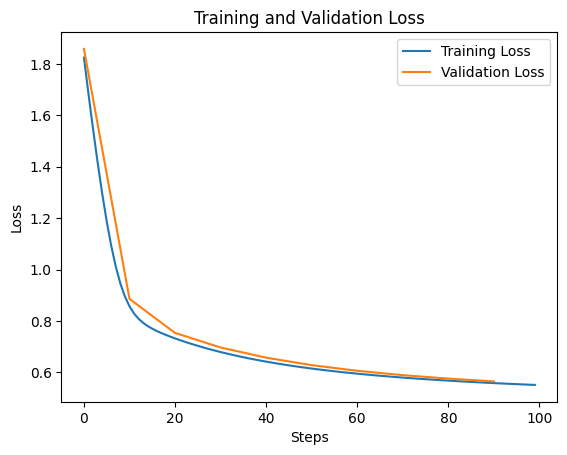

In [ ]:
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(0, len(val_losses) * valid_steps, valid_steps), val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Resultados en el conjunto de test

In [ ]:
print(f'Learned logistic regressor: y = σ({weights[0]:.2f}*x1 + {weights[1]:.2f}*x2 + {bias.item():.2f})')
y_pred = forward(X_test, weights, bias)
loss = binary_cross_entropy(y_test, y_pred).item()
print(f'Binary cross-entropy on the test set: {loss:.2f}')
prediction = y_pred > 0.5
correct = prediction == y_test
accuracy = (torch.sum(correct) / y_test.shape[0])*100
print (f'Accuracy on the test set: {accuracy:.2f}%')

Learned logistic regressor: y = σ(0.52*x1 + -0.50*x2 + 0.39)
Binary cross-entropy on the test set: 0.56
Accuracy on the test set: 70.67%


# Ejercicio 2: Regresor logístico multinomial

Estudia las probabilidades emitidas por el modelo ya entrenado para cada clase tanto con las frases del cuaderno como con algunas frases nuevas que tú propongas. Juega con frases que estén a medio camino entre diferentes temáticas.

In [ ]:
%pip install torch transformers numpy sentence_transformers

## Semilla de aleatoriedad

In [ ]:
import os
# set before importing pytorch to avoid all non-deterministic operations on GPU
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)

set_seed(42)  # to ensure reproducibility

## Obtención de los datos

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn

sentences = ['That is a happy person', 'That is a very happy person', 'That is a sad person', 'My drawing was not a picture of a hat']

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_embedding = SentenceTransformer('thenlper/gte-small', device=device)
embeddings = model_embedding.encode(sentences, convert_to_tensor=True)

print(f"embeddings.shape={embeddings.shape}")
print(f"embeddings[0][:3]={embeddings[0][:3]}")  # first 3 dimensions of the first sentence

cos = nn.CosineSimilarity(dim=0)
# works on dim=1 by default (assuming two batches of tensors to compare, but there is only dim=0 in our case)

print(f"Cosine similarity between '{sentences[0]}' and '{sentences[1]}' is {cos(embeddings[0], embeddings[1]).item():.3f}")
print(f"Cosine similarity between '{sentences[0]}' and '{sentences[2]}' is {cos(embeddings[0], embeddings[2]).item():.3f}")
print(f"Cosine similarity between '{sentences[0]}' and '{sentences[3]}' is {cos(embeddings[0], embeddings[3]).item():.3f}")

Using device: cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


embeddings.shape=torch.Size([4, 384])
embeddings[0][:3]=tensor([-0.0532,  0.0104,  0.0619])
Cosine similarity between 'That is a happy person' and 'That is a very happy person' is 0.982
Cosine similarity between 'That is a happy person' and 'That is a sad person' is 0.898
Cosine similarity between 'That is a happy person' and 'My drawing was not a picture of a hat' is 0.752


## Preparación del dataset

In [ ]:
sentences_train = [
    # politics:
    'The election results were surprising',
    'The new policy on healthcare was announced',
    'The government passed a new education reform',
    # sports:
    'The soccer team won the championship',
    'The Olympics will be held next year',
    'She won the gold medal in swimming',
    # culture:
    'The museum exhibited contemporary art',
    'The film festival was a huge success',
    'The concert was sold out'
]

labels_train = [0, 0, 0, 1, 1, 1, 2, 2, 2]  # 0: politics, 1: sports, 2: culture

sentences_test = [
    'A new law was proposed',
    'The basketball game was exciting',
    'The opera was a beautiful experience'
]

labels_test = [0, 1, 2]

embeddings_train = model_embedding.encode(sentences_train, convert_to_tensor=True)
embeddings_test = model_embedding.encode(sentences_test, convert_to_tensor=True)
labels_train = torch.tensor(labels_train).to(device)
labels_test = torch.tensor(labels_test).to(device)

print(f"type(embeddings_train)={type(embeddings_train)}")
print(f"embeddings_train.shape={embeddings_train.shape}")
print(f"embeddings_train[0][:3]={embeddings_train[0][:3]}")

type(embeddings_train)=<class 'torch.Tensor'>
embeddings_train.shape=torch.Size([9, 384])
embeddings_train[0][:3]=tensor([-0.0382,  0.0470,  0.0139])


## Definición del modelo

In [ ]:
import torch.nn.functional as F

class SoftmaxRegressor(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, X):
        return F.log_softmax(self.linear(X), dim=1)

## Instanciación del modelo

In [ ]:
input_size = embeddings_train.size(1)  # input embedding size to avoid magic numbers
num_classes = 3  # number of topics
learning_rate = 0.005

model = SoftmaxRegressor(input_size, num_classes)
model.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Entrenamiento

Step [0/10000], loss: 1.0995
Step [1000/10000], loss: 0.9784
Step [2000/10000], loss: 0.8737
Step [3000/10000], loss: 0.7831
Step [4000/10000], loss: 0.7048
Step [5000/10000], loss: 0.6371
Step [6000/10000], loss: 0.5786
Step [7000/10000], loss: 0.5278
Step [8000/10000], loss: 0.4836
Step [9000/10000], loss: 0.4450
Step [10000/10000], loss: 0.4112


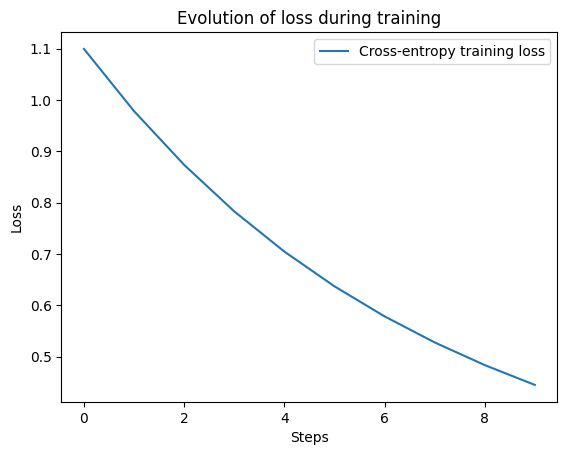

In [ ]:
training_steps = 10000
eval_steps = 1000

model.train()
losses = []
for i in range(training_steps):
    outputs = model(embeddings_train)
    loss = criterion(outputs, labels_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % eval_steps == 0:
        print(f'Step [{i}/{training_steps}], loss: {loss.item():.4f}')
        losses.append(loss.item())

print(f'Step [{training_steps}/{training_steps}], loss: {loss.item():.4f}')

import matplotlib.pyplot as plt

# plot training loss:
plt.plot(losses, label='Cross-entropy training loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Evolution of loss during training')
plt.legend()
plt.show()


## Evaluación

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = len(embeddings_test)
    outputs = model(embeddings_test)
    print(f'outputs={outputs}')
    predicted = torch.argmax(outputs, dim=1)
    print(f'predicted={predicted}')
    correct += (predicted == labels_test).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy on test data: {accuracy:.2f}%')

outputs=tensor([[-0.6570, -1.3148, -1.5462],
        [-1.2667, -0.8698, -1.2066],
        [-1.4698, -1.3536, -0.6700]])
predicted=tensor([0, 1, 2])
Accuracy on test data: 100.00%


En este caso se observa un 100% de acierto en el conjunto de datos de test, no es sorprendente ya que las frases a predecir son sencillas.

## Exportación del modelo

In [ ]:
torch.save(model.state_dict(), 'model.pth')
loaded_model = SoftmaxRegressor(input_size, num_classes)
loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model.eval()

SoftmaxRegressor(
  (linear): Linear(in_features=384, out_features=3, bias=True)
)

## Probabilidades de las frases utilizadas en el entrenamiento

In [ ]:
print("Frases de entrenamiento:")
for i, sentence in enumerate(sentences_train):
    print(f'Frase: "{sentence}"')
    print(f'Clase real: {labels_train[i]}')
    print()

embeddings_train = model_embedding.encode(sentences_train, convert_to_tensor=True)

model.eval()
with torch.no_grad():
    outputs_train = model(embeddings_train)
    probabilities_train = torch.exp(outputs_train)
    predicted_labels_train = torch.argmax(outputs_train, dim=1)

print("Probabilidades de pertenencia a cada clase para las frases de entrenamiento:")
for i, sentence in enumerate(sentences_train):
    print(f'Frase: "{sentence}"')
    print(f'Probabilidades: {probabilities_train[i]}')
    print(f'Clase predicha: {predicted_labels_train[i]}')
    print()



Frases de entrenamiento:
Frase: "The election results were surprising"
Clase real: 0

Frase: "The new policy on healthcare was announced"
Clase real: 0

Frase: "The government passed a new education reform"
Clase real: 0

Frase: "The soccer team won the championship"
Clase real: 1

Frase: "The Olympics will be held next year"
Clase real: 1

Frase: "She won the gold medal in swimming"
Clase real: 1

Frase: "The museum exhibited contemporary art"
Clase real: 2

Frase: "The film festival was a huge success"
Clase real: 2

Frase: "The concert was sold out"
Clase real: 2

Probabilidades de pertenencia a cada clase para las frases de entrenamiento:
Frase: "The election results were surprising"
Probabilidades: tensor([0.6133, 0.1850, 0.2017])
Clase predicha: 0

Frase: "The new policy on healthcare was announced"
Probabilidades: tensor([0.7007, 0.1633, 0.1360])
Clase predicha: 0

Frase: "The government passed a new education reform"
Probabilidades: tensor([0.7235, 0.1486, 0.1279])
Clase predic

En las frases de entrenamiento el modelo presenta un 100% de acierto.

En cuanto a las frases de la categiria 0, las políticas, las probabilidades de pertenencia a la clase son muy superiores, teniendo la mas pequela de las 3 un valor de 0.61, lo que indica que el modelo predice con bastante confianza las frases politicas.

En cuanto al resto de categorias, las predicciones del modelo tambien disponen de mucha confianza, esto puede ser debido a la simpleza de las frases o a las palabras clave de las que disponen.

In [ ]:
print("Frases de test:")
for i, sentence in enumerate(sentences_test):
    print(f'Frase: "{sentence}"')
    print(f'Clase real: {labels_test[i]}')
    print()

embeddings_test = model_embedding.encode(sentences_test, convert_to_tensor=True)

with torch.no_grad():
    outputs_test = model(embeddings_test)
    probabilities_test = torch.exp(outputs_test)
    predicted_labels_test = torch.argmax(outputs_test, dim=1)

print("Probabilidades de pertenencia a cada clase para las frases de prueba:")
for i, sentence in enumerate(sentences_test):
    print(f'Frase: "{sentence}"')
    print(f'Probabilidades: {probabilities_test[i]}')
    print(f'Clase predicha: {predicted_labels_test[i]}')
    print()


Frases de test:
Frase: "A new law was proposed"
Clase real: 0

Frase: "The basketball game was exciting"
Clase real: 1

Frase: "The opera was a beautiful experience"
Clase real: 2

Probabilidades de pertenencia a cada clase para las frases de prueba:
Frase: "A new law was proposed"
Probabilidades: tensor([0.5184, 0.2685, 0.2131])
Clase predicha: 0

Frase: "The basketball game was exciting"
Probabilidades: tensor([0.2818, 0.4190, 0.2992])
Clase predicha: 1

Frase: "The opera was a beautiful experience"
Probabilidades: tensor([0.2300, 0.2583, 0.5117])
Clase predicha: 2



Seguidamente, se observan las frases utilizadas para la validación.

En este caso, el modelo obtiene también un 100% de acierto pero las probabilidades son mas reducidas en comparación con las frases de entrenamiento, sobre todo la segunda frase, en la que la probabilidad de pertenecer a la categoria correcta es de únicamente de un 0.42.

## Predicción de nuevas frases

In [ ]:
sentences = [
  'The new president announced measures to combat unemployment.',
  'Protests were held across the country over the proposed tax reform.',
  'The basketball team won its tenth consecutive championship.',
  'The World Cup was hold in Qatar last year.',
  'Famous playwrights new play will open this weekend.',
  'The classical art exhibition attracted thousands of football fans to the museum.',
  'The cup won by FCB is on display at the museum',
  'The president of the soccer club will inaugurate a contemporary art exhibition at the stadium',
  'The government announced a new investment in the restoration of historic sites and museums as part of its cultural policy.'
]

embeddings_new_sent = model_embedding.encode(sentences, convert_to_tensor=True)

model.eval()
with torch.no_grad():
    outputs = model(embeddings_new_sent)
    probabilities = torch.exp(outputs)  # Probabilidades de pertenencia a cada clase
    predicted_labels = torch.argmax(outputs, dim=1)  # Clase predicha para cada frase

print('0: politics, 1: sports, 2: culture\n')

for i, sentence in enumerate(sentences):
    print(f'Frase: "{sentence}"')
    print(f'Probabilidades: {probabilities[i]}')
    print(f'Clase predicha: {predicted_labels[i]}')
    print()


0: politics, 1: sports, 2: culture

Frase: "The new president announced measures to combat unemployment."
Probabilidades: tensor([0.5558, 0.2418, 0.2023])
Clase predicha: 0

Frase: "Protests were held across the country over the proposed tax reform."
Probabilidades: tensor([0.5047, 0.1982, 0.2971])
Clase predicha: 0

Frase: "The basketball team won its tenth consecutive championship."
Probabilidades: tensor([0.2586, 0.5017, 0.2396])
Clase predicha: 1

Frase: "The World Cup was hold in Qatar last year."
Probabilidades: tensor([0.2274, 0.5009, 0.2717])
Clase predicha: 1

Frase: "Famous playwrights new play will open this weekend."
Probabilidades: tensor([0.2925, 0.2623, 0.4452])
Clase predicha: 2

Frase: "The classical art exhibition attracted thousands of football fans to the museum."
Probabilidades: tensor([0.1707, 0.2760, 0.5533])
Clase predicha: 2

Frase: "The cup won by FCB is on display at the museum"
Probabilidades: tensor([0.2115, 0.3673, 0.4211])
Clase predicha: 2

Frase: "The p

Para finalizar, se han creado nuevas frases, para las cuales las primeras 5 el modelo predice correctamente y con bastante confianza.

En las últimas 4 se ha intentado engañar al modelo, con frases que mezclan varias categorias.

para la frase número 6, se ha intentado engañar al modelo añadiendo las palabras fans del futblol, pero el modelo ha predicho la clase correcta con un 55% de probabilidad.

En la proxima frase, ambas categorias (deportes y cultura) obtienen probabilidades altas, pero es dificil clasificarla, incluso para un humano.

La octava frase también ha intentado engañar al modelo de clasificación, pero la ha clasificado correctamente, aún teniendo ambas categorias una probabilidad bastante elevada.

Y para finalizar, la última frase es en la que más igualadas han estado las probabilidades de las 3 categorias, destacando la política con un 0.4 y la cultura con un 0.37. Pero finalmente el modelo también la ha clasificado de manera correcta.